# Plots of the IRF and Sensitivity computed using pyirf

#### Comment for the reader: <br>
This notebook will take the IRFs computed from the MC simulation using the code in IRFsobtaintion, and will compare the results for the configurations we state in the third code cell. By modifying the third cell to indicate the sub-arrays to be compared, and modifying a configuration file to set the legends for the plots, the notebook can be directly run to obtain the plots. 

#### Only the third code cell needs to be modified.

# 0. Required packages

In [1]:
import os

import numpy as np
import uproot
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
from matplotlib.ticker import ScalarFormatter

from pyirf.binning import bin_center
from pyirf.utils import cone_solid_angle



%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9, 6)

# 1. We run the .py file with the specified already introduced:


We need to make sure that the .py file, this notebook and the source files are in the same location

In [ ]:
import os
#--------------TO CHANGE--------------
file_directory = '' #Path to the file were we have stored the IRFs, typically the path to the IRFs obtainment folder
file_list = ['', #Names of the IRFs files from the configurations we want to compare
             '',
             '',
             '']
monitconfig='' #Identifier for the comparison we are going to make, free to choose. The configuration file will need
# to be named according to configurationfile in the next line.
#--------------END OF TO CHANGE(EXCEPT configurationfile IF NECESSARY)--------------
configurationfile='configsetup'+monitconfig+'.yaml'
resultsfile='results_'+monitconfig+'.pdf'
resultsfilepng='results_'+monitconfig+''
final_filelist=[]
for file_name in file_list:
    full_path = os.path.join(file_directory, file_name)
    final_filelist.append(full_path)


With this we obtain the current IRF + sensititivy output FITS format provided by this software.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
import math
import sys
import matplotlib.gridspec as gridspec
from pyirf.utils import cone_solid_angle
from matplotlib import rc
from labellines import labelLine, labelLines
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from pyirf.spectral import (
    PowerLaw,
    CRAB_HEGRA,
)
import gammapy.irf as girf
from gammapy.data import Observation
from gammapy.estimators import SensitivityEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.maps import MapAxis, RegionGeom
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, load_irf_dict_from_file, EnergyDispersion2D, Background3D, Background2D
import logging
import warnings
import yaml


In [7]:
PPUTlist=[]
i=0
for file in final_filelist:
    pre=QTable.read(os.path.join(file_directory, file), hdu='SENSITIVITY')[1:-1]['flux_sensitivity']
    data= np.array(pre.value)
    data = [float(x) if x != '———' else np.nan for x in data]
    nan_ind = np.where(np.isnan(data))[0]
    print(nan_ind )
    if i==0:
        pre0=pre
        nan_ind_alpha = np.where(np.isnan(data))[0]
    else:
        nan_ind = np.where(np.isnan(data))[0]
    #We will work with the one that has more nan values as it's the restrictive one
    nans=np.union1d(nan_ind_alpha, nan_ind)
    mask = np.ones(len(pre), dtype=bool)
    mask[nans] = False
    PPUTlist.append(np.prod(pre0[mask]/pre[mask])**(1/len(pre0[mask])))

    i=i+1
PPUTlist=np.array(PPUTlist)


[ 0 16 17 18 19 20]
[ 0 14 15 16 17 18 19]
[ 0 14 15 16 17 18 19]
[ 0 14 15 16 17]


In [8]:
rc('font', weight='bold')
#
def get_crab_plot(perc, emin, emax):

    energy_flux = []
    energy = np.linspace(emin, emax, 300000)
    
    for eng in energy:
             
        flux = (6.0e-10) * math.pow( (eng/(0.3)) , (-2.31 + (-0.26*math.log10((eng)/(0.3)))))
        e_flux = flux * eng**2 * 1.60218 * perc  
        energy_flux.append(e_flux)
     
    return energy, energy_flux

def get_background_from_pyirf_fits(pyirf_file):

    rad_max = QTable.read(pyirf_file, hdu='RAD_MAX')[0]
    bg_rate = QTable.read(pyirf_file, hdu='BACKGROUND')[0]
    reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])
    # 
    fov_bin = 0
    rate_bin = bg_rate['BKG'].T[:, fov_bin]
    # interpolate theta cut for given e reco bin
    e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
    e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])

    theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])
    # undo normalization
    rate_bin *= cone_solid_angle(theta_cut)
    rate_bin *= np.diff(reco_bins)
    bkg_eng = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1]
    bkg_rate = rate_bin.to_value(1 / u.s)[1:-1]
    bkg_eng_err = np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2
    
    return bkg_rate, bkg_eng, bkg_eng_err
#
def get_energy_bias_from_pyirf_fits(pyirf_file):

    bias_resolution = QTable.read(pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
    bias_eng        = 0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV)
    bias            = bias_resolution['resolution']
    bias_eng_err    = 0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV)
    
    return bias, bias_eng, bias_eng_err
#
def get_effective_area_from_pyirf_fits(pyirf_file):

    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA')[0]
    area_eng = 0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1]
    eff_area = area['EFFAREA'].to_value(u.m**2).T[1:-1, 0]
    area_eng_err = 0.5 * (area['ENERG_HI'] - area['ENERG_LO']).to_value(u.TeV)[1:-1]   
    
    return eff_area, area_eng, area_eng_err
#
def get_angular_res_from_pyirf_fits(pyirf_file):

    ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]
    ang_res_eng = 0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV)
    ang_res_eng = np.asarray(ang_res_eng)

    angular = ang_res['angular_resolution'].to_value(u.deg)
    angular = np.asarray(angular)

    ang_res_eng_err = 0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV)
    ang_res_eng_err = np.asarray(ang_res_eng_err)  
    
    return angular, ang_res_eng, ang_res_eng_err
#
def get_sensitivity_from_pyirf_fits(pyirf_file):
    unit=u.Unit('erg cm-2 s-1')
    #
    #
    sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1] 
    #

    # make it print nice
    sensitivity['reco_energy_low'].info.format = '.3g'
    sensitivity['reco_energy_high'].info.format = '.3g'
    sensitivity['reco_energy_center'].info.format = '.3g'
    sensitivity['relative_sensitivity'].info.format = '.2g'
    sensitivity['flux_sensitivity'].info.format = '.3g'

    for k in filter(lambda k: k.startswith('n_'), sensitivity.colnames):
        sensitivity[k].info.format = '.1f'
        
    eng = sensitivity['reco_energy_center'] #e
    width = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low']) #w
    sens = (eng**2 * sensitivity['flux_sensitivity'])*1.60218  #This value wasn't in the other code why is it here now
    
    #
    finsens=sens   
    fineng=eng    
    finwidth= eng 
    
    return finsens, fineng, finwidth
#
def get_plot_options(config):

    plot_color_list = []
    marker_list     = []
    legend_list     = []
    method_list     = []
    livetime_list   = []


    for _irflist in config['DL2-INPUTS']:
        plot_color_list.append(_irflist['PLOTCOLOR'])  
        marker_list.append(_irflist['MARKERTYPE']) 
        legend_list.append(_irflist['LEGEND'])
        method_list.append(_irflist['SENSITIVITYMETHOD'])
        livetime_list.append(_irflist['OBS-TIME']["value"])

        
    return plot_color_list, marker_list, legend_list, method_list, livetime_list

def SensitivityInfo(pyirf_file):
    unit=u.Unit('erg cm-2 s-1')
    #
    # 
    sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1] 
    #

    # 
    sensitivity['reco_energy_low'].info.format = '.3g'
    sensitivity['reco_energy_high'].info.format = '.3g'
    sensitivity['reco_energy_center'].info.format = '.3g'
    sensitivity['relative_sensitivity'].info.format = '.2g'
    sensitivity['flux_sensitivity'].info.format = '.3g'

    for k in filter(lambda k: k.startswith('n_'), sensitivity.colnames):
        sensitivity[k].info.format = '.1f'
        
    e = sensitivity['reco_energy_center']
    w = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low'])
    s = (e**2 * sensitivity['flux_sensitivity'])

    #
    news=np.array(s.to_value(unit));
    sens=news  
    eng=e  
    weight=w    
    return sens, eng, weight
#
def DirectionCut(pyirf_file):
    
    rad_max = QTable.read(pyirf_file, hdu='RAD_MAX')[0]
    #Theta cut
    recE=0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV)
    thetacut= rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg)
    errrecE= 0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV)
    #G/H cut
    gh_cut = QTable.read(pyirf_file, hdu='GH_CUTS')[1:-1] # 
    recEGH= 0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV)
    GHcut=gh_cut['cut']
    errrecEGH=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV)
    return recE, thetacut, errrecE, recEGH, GHcut, errrecEGH
#the code creates a figure with three polar subplots, each showing the Point Spread Function (PSF) 
#for different energy bins.
#The PSF is represented in a radially symmetric way, and each subplot corresponds to a different energy bin 
#with the corresponding title indicating the energy value. The PSF is displayed as a 2D representation in polar 
#coordinates.

def PSF(pyirf_file):    
    psf_table = QTable.read(pyirf_file, hdu='PSF')[0]
    # select the only fov offset bin
    psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)
    # This extracts the radial point spread function (RPSF) from the psf_table, transposes it, and converts
    #the values to units of 1/steradian (1 / u.sr). The RPSF represents the PSF as a function of the off-axis
    #angle and is radially symmetric.

    offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
    #This creates an array of off-axis angle bins from the RAD_LO and RAD_HI columns of the psf_table.
    phi_bins = np.linspace(0, 2 * np.pi, 100)
    #This creates an array of 100 equally spaced values in the range 0 to 2π, representing the azimuthal angle.



    # 2d representation of the radially symmetric PSF
    r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)
    #This creates a meshgrid of r and phi values using the offset angle bins and the azimuthal angle bins.

    # look at a single energy bin
    # repeat values for each phi bin
    center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])
    #This calculates the energy center for each energy bin.
    return psf, phi_bins, phi, r, center

# Profile
def PSFnotcircular(pyirf_file):
    #D25-----------------------------------------
    psf_table = QTable.read(pyirf_file, hdu='PSF')[0]
    
    psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

    offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
    phi_bins = np.linspace(0, 2 * np.pi, 100)



    #  2d representation of the radially symmetric PSF
    r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

    # look at a single energy bin
    # repeat values for each phi bin
    center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


    center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
    xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

    return center, psf, xerr
    

In [9]:
def plot_complete_comparison(config):

    emin        = config['GENERALOPTIONS']['ENERGY-MIN']["value"] * u.Unit(config['GENERALOPTIONS']['ENERGY-MIN']["unit"])
    emax        = config['GENERALOPTIONS']['ENERGY-MAX']["value"] * u.Unit(config['GENERALOPTIONS']['ENERGY-MAX']["unit"])
    emin_nodimension = config['GENERALOPTIONS']['ENERGY-MIN']["value"]
    emax_nodimension = config['GENERALOPTIONS']['ENERGY-MAX']["value"]
    nbin_e_true = int((math.log10(emax_nodimension)- math.log10(emin_nodimension))*config['GENERALOPTIONS']['TRUE_ENERGY_BINS_PER_DECADE'])
    nbin_e_reco = int((math.log10(emax_nodimension)- math.log10(emin_nodimension))*config['GENERALOPTIONS']['RECO_ENERGY_BINS_PER_DECADE'])
    energy_axis_true_fine = MapAxis.from_energy_bounds(emin,emax,nbin=100, name="energy_true")
    energy_axis_true = MapAxis.from_energy_bounds(emin,emax,nbin=nbin_e_true)
    energy_axis_reco = MapAxis.from_energy_bounds(emin,emax,nbin=nbin_e_reco)

    offset      = config['GENERALOPTIONS']['OFFSET-ANGLE']["value"]
    containment = config['GENERALOPTIONS']['THETACUT_PERCENTILE']*0.01

    plot_color_list, marker_list, legend_list, method_list, livetime_list = get_plot_options(config)

    fontsize            = config['FIGUREOPTIONS']['FONTSIZE']
    figsize_x           = 22#config['FIGUREOPTIONS']['FIGSIZE'][0]
    figsize_y           = 18#config['FIGUREOPTIONS']['FIGSIZE'][1]
    use_y_axis_format   = config['FIGUREOPTIONS']['USE-Y-AXIS-FORMAT']
    digit_format        = '%' + config['FIGUREOPTIONS']['Y-AXIS-FORMAT']
    control_ang_eng_res = config['FIGUREOPTIONS']['CONTROL-ANG-ENG-RES-RANGE']
    angres_range        = [config['FIGUREOPTIONS']['ANG-RES-RANGE'][0],config['FIGUREOPTIONS']['ANG-RES-RANGE'][1]]    
    engres_range        = [config['FIGUREOPTIONS']['ENG-RES-RANGE'][0],config['FIGUREOPTIONS']['ENG-RES-RANGE'][1]]  
    inverse_sensitivity = config['FIGUREOPTIONS']['INVERSE-SENSITIVITY-RATIO']

    if(config['FIGUREOPTIONS']['CONSTRAINED']):

        fig = plt.figure(figsize=(figsize_x,figsize_y),layout="constrained")
    else:

        fig = plt.figure(figsize=(figsize_x,figsize_y))

    gs0  = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gridspec.GridSpecFromSubplotSpec(4, 3, subplot_spec=gs0[0])

    ax1  = fig.add_subplot(gs00[:-2, :])
    ax2  = fig.add_subplot(gs00[-2, :-1])
    ax3  = fig.add_subplot(gs00[-2, -1])
    axa  = fig.add_subplot(gs00[-1, :])

    # the following syntax does the same as the GridSpecFromSubplotSpec call above:
    gs01 = gs0[1].subgridspec(4, 2)
    
    ax4  = fig.add_subplot(gs01[0,0])
    ax5  = fig.add_subplot(gs01[0,1])
    ax6  = fig.add_subplot(gs01[1,0])
    ax7  = fig.add_subplot(gs01[1,1])
    ax8  = fig.add_subplot(gs01[2,0])
    ax9  = fig.add_subplot(gs01[2,1]) 
    axb  = fig.add_subplot(gs01[3,:])    
    
    if(config['FIGUREOPTIONS']['BOX-SHAPED']):
        ax4.set_box_aspect(1)
        ax5.set_box_aspect(1) 
        ax6.set_box_aspect(1)
        ax7.set_box_aspect(1) 
        ax8.set_box_aspect(1)
        ax9.set_box_aspect(1)  
        
    if(config['FIGUREOPTIONS']['FIXED-RANGE-RATIO']):
        ymin = config['FIGUREOPTIONS']['FIXED-RANGE-VALUE'][0]
        ymax = config['FIGUREOPTIONS']['FIXED-RANGE-VALUE'][1]
        ax2.set_ylim(ymin,ymax)
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax5.set_ylim(ymin,ymax)
        ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))    
        ax7.set_ylim(ymin,ymax) 
        ax7.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))            
        ax9.set_ylim(ymin,ymax)
        ax9.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))    
    
    crab_flux = [1.0, 0.1, 0.01, 0.001]        
    for crab in crab_flux:
        energy, energy_flux = get_crab_plot(crab, 0.01, 160.0)
        label_crab = str(100*crab)+'$\%$ Crab' 
        ax1.plot(energy, energy_flux, ls='--', color='gray', label=label_crab)
            
    labelLines(ax1.get_lines(), align=True,xvals=[2.0, 2.0, 2.0, 0.05])  
    line_sensitivities = []
    
    counter = 0

    for  _file, _color, _marker, _legend, _method, _livetime in zip(final_filelist, plot_color_list, marker_list, legend_list, method_list, livetime_list):

        # DEFAULT SENSITIVITY METHOD- checked
        
        sens, eng, width                      = get_sensitivity_from_pyirf_fits(_file)
        sens=np.array(sens); eng=np.array(eng); width=np.array(width);
        bias, bias_eng, bias_eng_err          = get_energy_bias_from_pyirf_fits(_file)
        aeff, aeff_eng, aeff_err              = get_effective_area_from_pyirf_fits(_file)
        bkg_rate, bkg_eng, bkg_eng_err        = get_background_from_pyirf_fits(_file)
        angular, ang_res_eng, ang_res_eng_err = get_angular_res_from_pyirf_fits(_file)
        recE, thetacut, errrecE, recEGH, GHcut, errrecEGH = DirectionCut(_file)
            
        if (counter == 0):
            
            ref_sens     = sens
            ref_bias     = bias
            ref_eff_area = aeff 
            ref_bkg_rate = bkg_rate
            ref_ang_res  = angular
        
        sens_ratio = sens / ref_sens
        aeff_ratio = aeff / ref_eff_area
        bkg_ratio  = bkg_rate / ref_bkg_rate    
        ang_res_ratio = angular / ref_ang_res    
        
        
        if(inverse_sensitivity):
        
            sens_ratio = 1 / sens_ratio
            
        senstry, engtry, widthtry = SensitivityInfo(_file)
        
        

        line_sens = ax1.errorbar(engtry, senstry, xerr=widthtry / 2, ls='', markersize = 5, elinewidth=2, capsize = 2, capthick = 2, color=_color, label=_legend, marker=_marker)
        line_sensitivities.append(line_sens)        
        ax3.errorbar(bias_eng, bias, xerr=bias_eng_err, ls='-', markersize = 5, color=_color, marker=_marker)
        ax4.errorbar(aeff_eng, aeff, xerr=aeff_err, ls='-', markersize = 5, color=_color, marker=_marker)    
        ax6.errorbar(bkg_eng, bkg_rate, xerr=bkg_eng_err, ls='-', markersize = 5, color=_color, marker=_marker)    
        ax8.errorbar(ang_res_eng, angular, xerr=ang_res_eng_err, ls='-', markersize = 5, color=_color, marker=_marker)   

        axa.errorbar(recEGH, GHcut, xerr=errrecEGH, ls='', markersize = 5, elinewidth=2, capsize = 2, capthick = 2, color=_color, marker=_marker)
        axb.errorbar(recE, thetacut, xerr=errrecE, ls='', markersize = 3, elinewidth=2, capsize = 2, capthick = 2, color=_color, marker=_marker) 



        if(counter == 0): 
        
            ax2.axhline(1.0, ls = '--', color=_color, lw = 2)
            ax5.axhline(1.0, ls = '--', color=_color, lw = 2)            
            ax7.axhline(1.0, ls = '--', color=_color, lw = 2)  
            ax9.axhline(1.0, ls = '--', color=_color, lw = 2)                      
        
        else:

            ax2.errorbar(eng, sens_ratio, xerr=width/2, ls='', markersize = 5, elinewidth=2, capsize = 2, capthick = 2, color=_color, marker=_marker)    
            ax5.errorbar(aeff_eng, aeff_ratio, xerr=aeff_err, ls='-', markersize = 5, color=_color, marker=_marker)   
            ax7.errorbar(bkg_eng, bkg_ratio, xerr=bkg_eng_err, ls='-', markersize = 5, color=_color, marker=_marker)
            ax9.errorbar(ang_res_eng, ang_res_ratio, xerr=ang_res_eng_err, ls='--', markersize = 5, color=_color, marker=_marker)    
    
        counter = counter + 1
        
    allaxes = fig.get_axes()
    
    for _ax in allaxes:
        _ax.set_xscale("log")
        _ax.set_xlabel("Energy [TeV]",fontsize=fontsize, weight='bold')
        _ax.tick_params(axis='x', labelsize=fontsize)
        _ax.tick_params(axis='y', labelsize=fontsize) 
        _ax.tick_params(right=True, top=True)         

    ax1.legend(handles=line_sensitivities ,fontsize=fontsize, loc='upper right')     
    ax1.set_yscale("log")
    p=10
    ax1.set_ylim(9e-15, 2e-10) #
    ax1.set_xlim(0, 1e1+p)
    ax3.set_xlim(0, 1e1+p)
    ax4.set_xlim(0, 1e1+p)
    ax6.set_xlim(0, 1e1+p)
    ax8.set_xlim(0, 1e1+p)
    ax1.set_ylabel(rf"E$^{2}$ $\times$ FluxSensitivity [erg cm$^{-2}$ s$^{-1}$]", fontsize=fontsize, weight='bold')
    ax2.set_ylabel(rf"Sensitivity Ratio", fontsize=fontsize, weight='bold')
    ax3.set_ylabel(rf"Energy Resolution", fontsize=fontsize, weight='bold')  
    ax3.set_ylim(bottom=0)
    ax4.set_yscale("log")
    ax4.set_ylabel(rf"Effective Area [m$^{2}$]", fontsize=fontsize, weight='bold')  
    ax5.set_ylabel(rf"Effective Area Ratio", fontsize=fontsize, weight='bold')     
    ax6.set_yscale("log")
    ax6.set_ylabel(rf"Background Rate [1/s]", fontsize=fontsize, weight='bold')      
    ax7.set_ylabel(rf"Background Rate Ratio", fontsize=fontsize, weight='bold')    
    ax8.set_ylabel(rf"Angular Resolution [deg]", fontsize=fontsize, weight='bold')     
    ax8.set_ylim(bottom=0)
    ax9.set_ylabel(rf"Angular Resolution Ratio", fontsize=fontsize, weight='bold')    

    axa.set_ylabel('G/H-cut', fontsize=fontsize, weight='bold')
    axa.set_xlabel("Reconstructed energy [TeV]",fontsize=fontsize, weight='bold')
    axa.set_xscale('log')
    axa.set_xlim((10**(-2), 10**(2)-70))
    axa.set_ylim((0.20, 0.35)) 

    axb.set_ylabel('$\Theta$-cut', fontsize=fontsize, weight='bold')
    axb.set_xlabel("Reconstructed energy [TeV]",fontsize=fontsize, weight='bold')
    axb.set_xscale('log')
    axb.set_xlim((10**(-2), 10**(2)+150))
    axb.set_ylim((0.00, 0.35))  
    
    if(use_y_axis_format):
        ax2.yaxis.set_major_formatter(FormatStrFormatter(digit_format))   
        ax3.yaxis.set_major_formatter(FormatStrFormatter(digit_format))   
        ax8.yaxis.set_major_formatter(FormatStrFormatter(digit_format))    
        
    if(control_ang_eng_res):
        ax3.set_ylim(bottom=engres_range[0], top=engres_range[1])
        ax8.set_ylim(bottom=angres_range[0], top=angres_range[1])   
    #We add the PPUT values
    # Convert the calculated values to a formatted string
    calculated_values_str = "\n".join(["{:.7f}".format(value) for value in PPUTlist])
    text = f"PPUT values:\n{calculated_values_str}"
    bbox_props = dict(edgecolor="grey", facecolor="white")
    ax1.text(0.98, 0.02, text, ha="right", va="bottom", transform=ax1.transAxes, fontsize=15, bbox=bbox_props)


/Users/julialagunamiralles/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/1l/vydck6jn2r3g9d3rypt4jf240000gn/T/ipykernel_3794/2559427374.py:108: RuntimeWarning: invalid value encountered in divide
  bkg_ratio  = bkg_rate / ref_bkg_rate
/Users/julialagunamiralles/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/1l/vydck6jn2r3g9d3rypt4jf240000gn/T/ipykernel_3794/2559427374.py:108: RuntimeWarning: invalid value encountered in divide
  bkg_ratio  = bkg_rate / ref_bkg_rate
/Users/julialagunamiralles/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, m

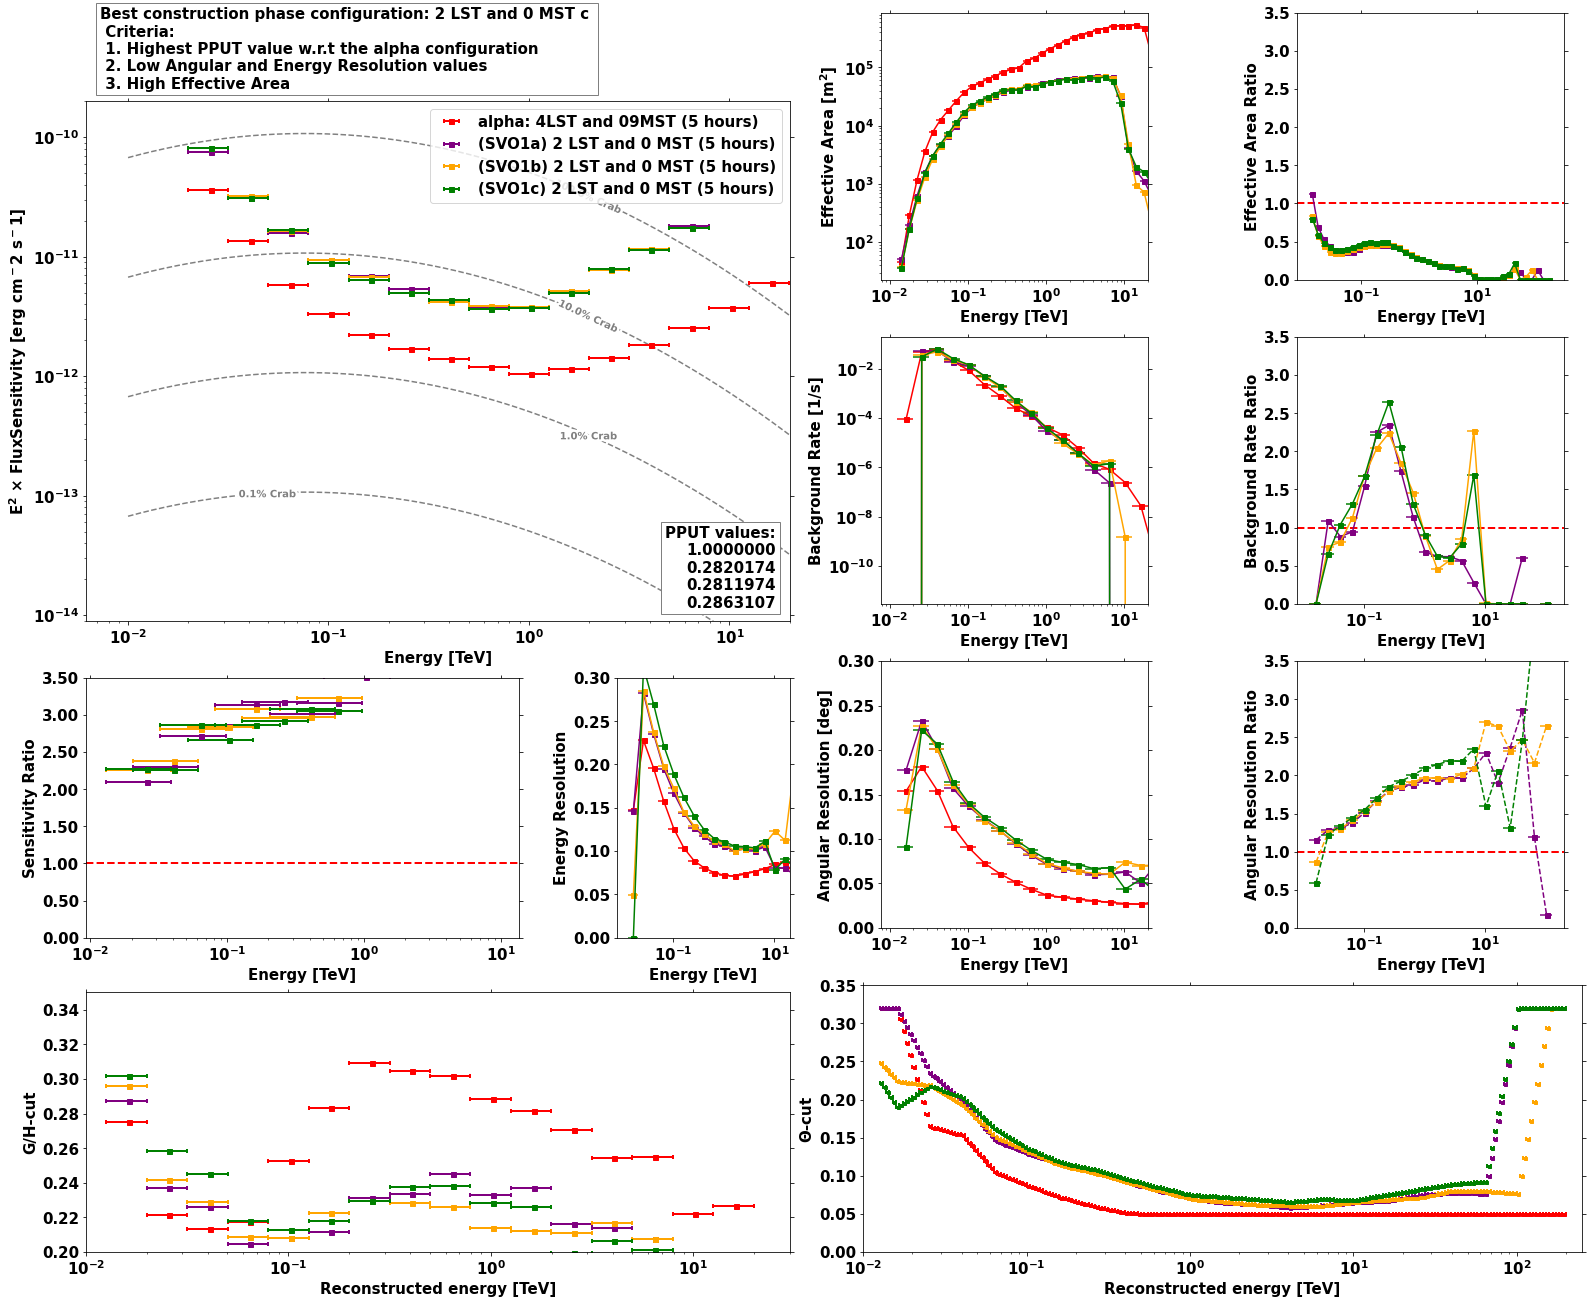

In [10]:
configuration = yaml.safe_load(open(configurationfile))
plot_complete_comparison(config=configuration)

plt.savefig(resultsfile, bbox_inches='tight', dpi=300)
plt.savefig(resultsfilepng, bbox_inches='tight', dpi=300)
warnings.filterwarnings('ignore')


In [ ]:
PPUTlist

In [13]:
def plotPSF(config=configuration):

    plot_color_list, marker_list, legend_list, method_list, livetime_list = get_plot_options(config)

    fontsize            = config['FIGUREOPTIONS']['FONTSIZE']
    figsize_x           = config['FIGUREOPTIONS']['FIGSIZE'][0]
    figsize_y           = config['FIGUREOPTIONS']['FIGSIZE'][1]
    
    for _file, _filex, _color, _marker, _legend, _method, _livetime in zip(final_filelist, file_list, plot_color_list, marker_list, legend_list, method_list, livetime_list):
    
        psf, phi_bins, phi, r, center =PSF(_file)
        fig = plt.figure(figsize=(15, 5))
        axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]
        fig.suptitle(f'Point Spread Function for the {_filex} configuration')

        # The code then loops through three different energy bins (10, 20, and 30) and plots the PSF for each 
        #bin on separate polar subplots (axs) 
        for bin_id, ax in zip([10, 20, 30], axs):
            image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))

            ax.set_title(f'PSF @ {center[bin_id]:.2f} ')
            ax.pcolormesh(phi, r, image)
            ax.set_ylim(0, 0.25) 
            ax.set_aspect(1)  

       

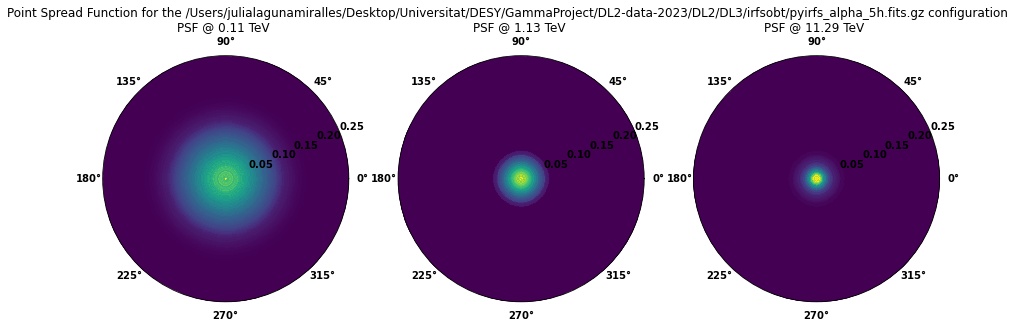

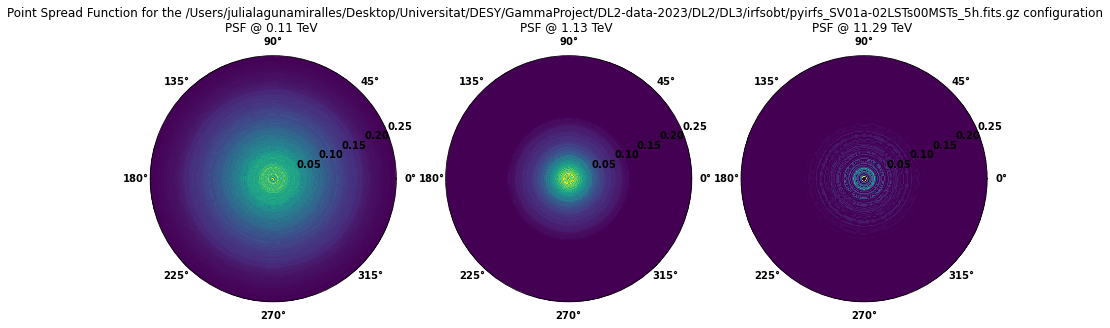

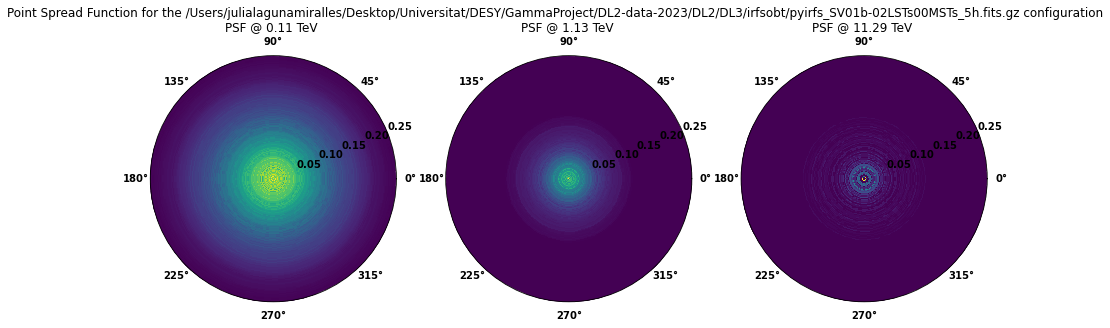

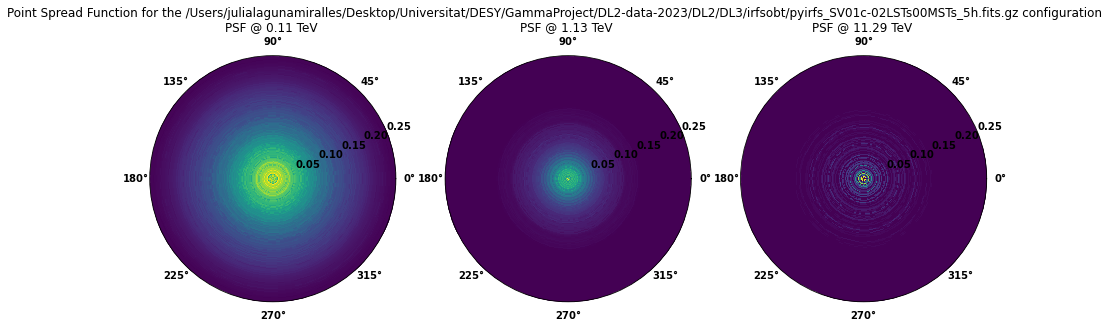

In [14]:
plotPSF(config=configuration)
